In [1]:
from drn_interactions.interactions.popcup import PopulationCoupling
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.loaders import SpontaneousActivityLoader
from drn_interactions.interactions.pairwise import PairwiseCorr, PairwisePartialCorr
from drn_interactions.interactions.runners import InteractionsRunner
from drn_interactions.io import load_derived_generic, load_neurons
from sklearn.metrics.pairwise import pairwise_distances
import pandas as pd

In [41]:
sessions = load_neurons()["session_name"].unique()
session = sessions[5]

loader = SpontaneousActivityLoader(session_name=session, shuffle=False)
preprocessor = InteractionsPreprocessor(z=True, minmax=False)
pcorr = PairwisePartialCorr(zero_diag=True, rectify=False, shuffle=True)
corr = PairwiseCorr(zero_diag=True, rectify=False, shuffle=True, remove_duplicate_combs=True)
pcup = PopulationCoupling()


In [42]:
df = loader()
df = preprocessor(df)
df_corr = pcorr.fit(df).get_adjacency_matrix()

/opt/miniconda3/envs/drn/lib/python3.8/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


0.03446330480299367


/opt/miniconda3/envs/drn/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


<AxesSubplot:>

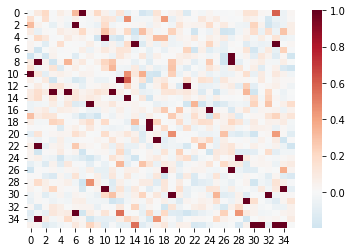

In [43]:
from sklearn.cluster import SpectralClustering
import networkx as nx
import seaborn as sns
import numpy as np

mod = SpectralClustering(n_clusters=3, affinity="precomputed")

def graph_from_df(df):
    labels = df.index.values
    values = df.values
    g = nx.from_numpy_matrix(values)
    g = nx.relabel_nodes(g, lambda x: labels[x])
    return g
    
mod.fit(df_corr + 1)

labs = mod.labels_
nodes = df_corr.columns.values
partition = [nodes[labs==i] for i in set(labs)]

g = graph_from_df(df_corr + 1)
q = nx.algorithms.community.modularity(g, partition, resolution=1)
print(q)
idx= np.argsort(labs)
dfp = df_corr.iloc[idx, idx]
# sns.heatmap(dfp.values, vmin=0, robust=True, cmap="Greys")
sns.heatmap(dfp.values, robust=True, center=0, cmap="RdBu_r")